In [12]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *
from einops import rearrange, reduce, repeat


torch.backends.cudnn.benchmark = True

img_wh = (400, 400)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['llff'] \
          ('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'val',
           img_wh=img_wh)

train_dataset = dataset_dict['llff'] \
          ('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'train',
           img_wh=img_wh)

val image is /ssd_scratch/cvit/shubham/nerf_llff_data/fern/images/IMG_4038.JPG


In [2]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = 'ckpts/ferns/epoch=12.ckpt'
# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [4]:
import ipyvolume as ipv

In [5]:
def sample_pdf(bins, weights, N_importance, det=False, eps=1e-5):
    """
    Sample @N_importance samples from @bins with distribution defined by @weights.
    Inputs:
        bins: (N_rays, N_samples_+1) where N_samples_ is "the number of coarse samples per ray - 2"
        weights: (N_rays, N_samples_)
        N_importance: the number of samples to draw from the distribution
        det: deterministic or not
        eps: a small number to prevent division by zero
    Outputs:
        samples: the sampled samples
    """
    N_rays, N_samples_ = weights.shape
    weights = weights + eps # prevent division by zero (don't do inplace op!)
    pdf = weights / reduce(weights, 'n1 n2 -> n1 1', 'sum') # (N_rays, N_samples_)
    cdf = torch.cumsum(pdf, -1) # (N_rays, N_samples), cumulative distribution function
    cdf = torch.cat([torch.zeros_like(cdf[: ,:1]), cdf], -1)  # (N_rays, N_samples_+1) 
                                                               # padded to 0~1 inclusive

    if det:
        u = torch.linspace(0, 1, N_importance, device=bins.device)
        u = u.expand(N_rays, N_importance)
    else:
        u = torch.rand(N_rays, N_importance, device=bins.device)
    u = u.contiguous()

    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.clamp_min(inds-1, 0)
    above = torch.clamp_max(inds, N_samples_)

    inds_sampled = rearrange(torch.stack([below, above], -1), 'n1 n2 c -> n1 (n2 c)', c=2)
    cdf_g = rearrange(torch.gather(cdf, 1, inds_sampled), 'n1 (n2 c) -> n1 n2 c', c=2)
    bins_g = rearrange(torch.gather(bins, 1, inds_sampled), 'n1 (n2 c) -> n1 n2 c', c=2)

    denom = cdf_g[...,1]-cdf_g[...,0]
    denom[denom<eps] = 1 # denom equals 0 means a bin has weight 0,
                         # in which case it will not be sampled
                         # anyway, therefore any value for it is fine (set to 1 here)

    samples = bins_g[...,0] + (u-cdf_g[...,0])/denom * (bins_g[...,1]-bins_g[...,0])
    return samples

In [6]:
def render_rays(models,
                embeddings,
                rays,
                N_samples=64,
                use_disp=False,
                perturb=0,
                noise_std=1,
                N_importance=0,
                chunk=1024*32,
                white_back=False,
                test_time=False,
                **kwargs
                ):
    """
    Render rays by computing the output of @model applied on @rays
    Inputs:
        models: list of NeRF models (coarse and fine) defined in nerf.py
        embeddings: list of embedding models of origin and direction defined in nerf.py
        rays: (N_rays, 3+3+2), ray origins and directions, near and far depths
        N_samples: number of coarse samples per ray
        use_disp: whether to sample in disparity space (inverse depth)
        perturb: factor to perturb the sampling position on the ray (for coarse model only)
        noise_std: factor to perturb the model's prediction of sigma
        N_importance: number of fine samples per ray
        chunk: the chunk size in batched inference
        white_back: whether the background is white (dataset dependent)
        test_time: whether it is test (inference only) or not. If True, it will not do inference
                   on coarse rgb to save time
    Outputs:
        result: dictionary containing final rgb and depth maps for coarse and fine models
    """

    def inference(results, model, typ, xyz, z_vals, test_time=False, **kwargs):
        """
        Helper function that performs model inference.
        Inputs:
            results: a dict storing all results
            model: NeRF model (coarse or fine)
            typ: 'coarse' or 'fine'
            xyz: (N_rays, N_samples_, 3) sampled positions
                  N_samples_ is the number of sampled points in each ray;
                             = N_samples for coarse model
                             = N_samples+N_importance for fine model
            z_vals: (N_rays, N_samples_) depths of the sampled positions
            test_time: test time or not
        Outputs:
            if weights_only:
                weights: (N_rays, N_samples_): weights of each sample
            else:
                rgb_final: (N_rays, 3) the final rgb image
                depth_final: (N_rays) depth map
                weights: (N_rays, N_samples_): weights of each sample
        """
        N_samples_ = xyz.shape[1]
        xyz_ = rearrange(xyz, 'n1 n2 c -> (n1 n2) c') # (N_rays*N_samples_, 3)

        # Perform model inference to get rgb and raw sigma
        B = xyz_.shape[0]
        out_chunks = []
        if typ=='coarse' and test_time and 'fine' in models:
            for i in range(0, B, chunk):
                xyz_embedded = embedding_xyz(xyz_[i:i+chunk])
                out_chunks += [model(xyz_embedded, sigma_only=True)]

            out = torch.cat(out_chunks, 0)
            sigmas = rearrange(out, '(n1 n2) 1 -> n1 n2', n1=N_rays, n2=N_samples_)
        else: # infer rgb and sigma and others
            dir_embedded_ = repeat(dir_embedded, 'n1 c -> (n1 n2) c', n2=N_samples_)
                            # (N_rays*N_samples_, embed_dir_channels)
            for i in range(0, B, chunk):
                xyz_embedded = embedding_xyz(xyz_[i:i+chunk])
                xyzdir_embedded = torch.cat([xyz_embedded,
                                             dir_embedded_[i:i+chunk]], 1)
                out_chunks += [model(xyzdir_embedded, sigma_only=False)]

            out = torch.cat(out_chunks, 0)
            # out = out.view(N_rays, N_samples_, 4)
            out = rearrange(out, '(n1 n2) c -> n1 n2 c', n1=N_rays, n2=N_samples_, c=4)
            rgbs = out[..., :3] # (N_rays, N_samples_, 3)
            sigmas = out[..., 3] # (N_rays, N_samples_)
            
        # Convert these values using volume rendering (Section 4)
        deltas = z_vals[:, 1:] - z_vals[:, :-1] # (N_rays, N_samples_-1)
        delta_inf = 1e10 * torch.ones_like(deltas[:, :1]) # (N_rays, 1) the last delta is infinity
        deltas = torch.cat([deltas, delta_inf], -1)  # (N_rays, N_samples_)

        # compute alpha by the formula (3)
        noise = torch.randn_like(sigmas) * noise_std
        alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise)) # (N_rays, N_samples_)

        alphas_shifted = \
            torch.cat([torch.ones_like(alphas[:, :1]), 1-alphas+1e-10], -1) # [1, 1-a1, 1-a2, ...]
        weights = \
            alphas * torch.cumprod(alphas_shifted[:, :-1], -1) # (N_rays, N_samples_)
        weights_sum = reduce(weights, 'n1 n2 -> n1', 'sum') # (N_rays), the accumulated opacity along the rays
                                                            # equals "1 - (1-a1)(1-a2)...(1-an)" mathematically

        # [CHANGES]: Added a softmax part on the weights here
        wts_sf = torch.nn.functional.softmax(weights*2, dim=-1)
        # print(sigmas.mean(-1).shape, sigmas_sf.shape)
        wts = wts_sf

        print(reduce(wts, 'n1 n2 -> n1', 'sum'), weights_sum)

        results[f'weights_{typ}'] = wts
        results[f'opacity_{typ}'] = weights_sum
        results[f'z_vals_{typ}'] = z_vals
        if test_time and typ == 'coarse' and 'fine' in models:
            return

        # rgb_map = reduce(rearrange(wts, 'n1 n2 -> n1 n2 1')*rgbs, 'n1 n2 c -> n1 c', 'sum')
        rgb_map = reduce(rearrange(weights, 'n1 n2 -> n1 n2 1')*rgbs, 'n1 n2 c -> n1 c', 'sum')

        depth_map = reduce(wts*z_vals, 'n1 n2 -> n1', 'sum')
        # depth_map = reduce(weights*z_vals, 'n1 n2 -> n1', 'sum')

        if white_back:
            rgb_map += 1-weights_sum.unsqueeze(1)

        results[f'rgb_{typ}'] = rgb_map
        results[f'depth_{typ}'] = depth_map

        return

    embedding_xyz, embedding_dir = embeddings['xyz'], embeddings['dir']

    # Decompose the inputs
    N_rays = rays.shape[0]
    rays_o, rays_d = rays[:, 0:3], rays[:, 3:6] # both (N_rays, 3)
    near, far = rays[:, 6:7], rays[:, 7:8] # both (N_rays, 1)
    # Embed direction
    dir_embedded = embedding_dir(kwargs.get('view_dir', rays_d)) # (N_rays, embed_dir_channels)

    rays_o = rearrange(rays_o, 'n1 c -> n1 1 c')
    rays_d = rearrange(rays_d, 'n1 c -> n1 1 c')

    # Sample depth points
    z_steps = torch.linspace(0, 1, N_samples, device=rays.device) # (N_samples)
    if not use_disp: # use linear sampling in depth space
        z_vals = near * (1-z_steps) + far * z_steps
    else: # use linear sampling in disparity space
        z_vals = 1/(1/near * (1-z_steps) + 1/far * z_steps)

    z_vals = z_vals.expand(N_rays, N_samples)
    
    if perturb > 0: # perturb sampling depths (z_vals)
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_rays, N_samples-1) interval mid points
        # get intervals between samples
        upper = torch.cat([z_vals_mid, z_vals[: ,-1:]], -1)
        lower = torch.cat([z_vals[: ,:1], z_vals_mid], -1)
        
        perturb_rand = perturb * torch.rand_like(z_vals)
        z_vals = lower + (upper - lower) * perturb_rand

    xyz_coarse = rays_o + rays_d * rearrange(z_vals, 'n1 n2 -> n1 n2 1')
    print("XYZ coarse shape: ", xyz_coarse.shape)

    results = {}
    inference(results, models['coarse'], 'coarse', xyz_coarse, z_vals, test_time, **kwargs)

    if N_importance > 0: # sample points for fine model
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_rays, N_samples-1) interval mid points
        z_vals_ = sample_pdf(z_vals_mid, results['weights_coarse'][:, 1:-1].detach(),
                             N_importance, det=(perturb==0))
                  # detach so that grad doesn't propogate to weights_coarse from here

        z_vals = torch.sort(torch.cat([z_vals, z_vals_], -1), -1)[0]
                 # combine coarse and fine samples

        xyz_fine = rays_o + rays_d * rearrange(z_vals, 'n1 n2 -> n1 n2 1')

        inference(results, models['fine'], 'fine', xyz_fine, z_vals, test_time, **kwargs)

    return results


In [7]:
def sample_points(
                rays,
                N_samples=64,
                use_disp=False,
                perturb=0,
                ):

    # Decompose the inputs
    N_rays = rays.shape[0]
    rays_o, rays_d = rays[:, 0:3], rays[:, 3:6] # both (N_rays, 3)
    near, far = rays[:, 6:7], rays[:, 7:8] # both (N_rays, 1)

    rays_o = rearrange(rays_o, 'n1 c -> n1 1 c')
    rays_d = rearrange(rays_d, 'n1 c -> n1 1 c')

    # Sample depth points
    z_steps = torch.linspace(0, 1, N_samples, device=rays.device) # (N_samples)
    if not use_disp: # use linear sampling in depth space
        z_vals = near * (1-z_steps) + far * z_steps
    else: # use linear sampling in disparity space
        z_vals = 1/(1/near * (1-z_steps) + 1/far * z_steps)

    z_vals = z_vals.expand(N_rays, N_samples)
    
    if perturb > 0: # perturb sampling depths (z_vals)
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_rays, N_samples-1) interval mid points
        # get intervals between samples
        upper = torch.cat([z_vals_mid, z_vals[: ,-1:]], -1)
        lower = torch.cat([z_vals[: ,:1], z_vals_mid], -1)
        
        perturb_rand = perturb * torch.rand_like(z_vals)
        z_vals = lower + (upper - lower) * perturb_rand

    xyz_coarse = rays_o + rays_d * rearrange(z_vals, 'n1 n2 -> n1 n2 1')
    print("XYZ coarse shape: ", xyz_coarse.shape)

    return xyz_coarse


In [8]:
# xval = np.random.random((10,))*0.7
# xval[4] = 1.3
# xval = xval /xval.sum()

# xs = torch.nn.functional.softmax(torch.tensor(xval) * 2.0)

# plt.plot(xval, '-o')
# plt.plot(xs)

# Sampling

Only sampling points here. Scroll more to do testings!

In [72]:
sample = train_dataset[:1024]
rays = sample['rays']
rays.shape

torch.Size([1024, 8])

In [15]:
train_dataset[0]['rays'].shape

torch.Size([8])

In [20]:
# np.arange(400*400)
400*400

160000

In [46]:
import skimage.io as sio
import cv2

img = cv2.resize(sio.imread("/ssd_scratch/cvit/shubham/nerf_llff_data/fern/images/IMG_4026.JPG"), (504, 378))
print(img.shape)

(378, 504, 3)


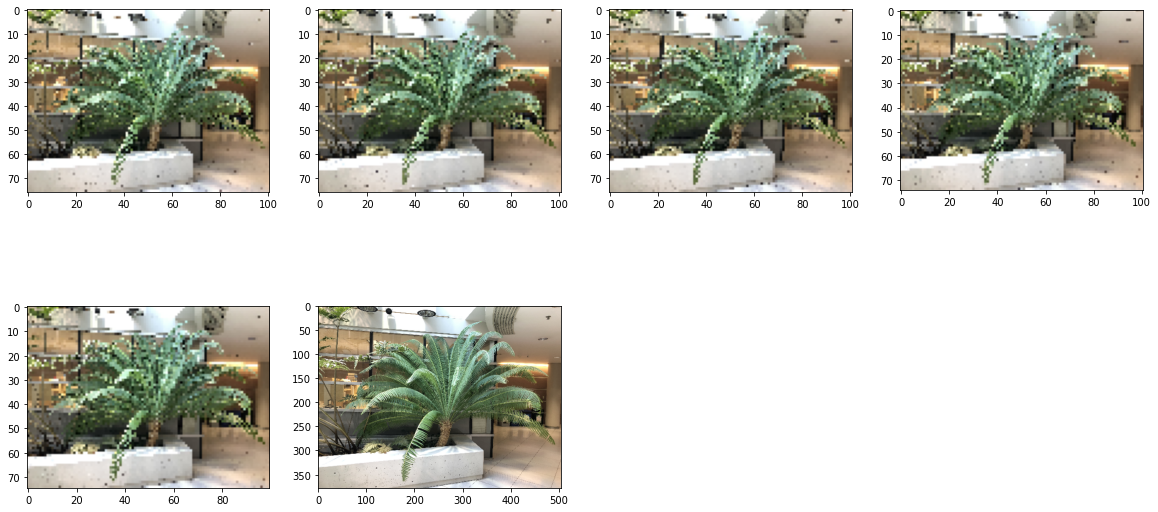

In [68]:
plt.figure(0, figsize=(20, 10))


space = 5
xs = 0
ys = 0
for ix in range(space):
    plt.subplot(2, 1 + (space+1)//2, ix+1)
    plt.imshow(img[ix::space, ix::space])

plt.subplot(2, 1 + (space+1)//2, space+1)
plt.imshow(img)

plt.show()

In [69]:
space = 5
xs = 0
ys = 0
for ix in range(space):
    shape = img[ix::space, ix::space].shape
    print(shape, shape[0]*shape[1])
    xs += shape[0]
    ys += shape[1]
print(xs, ys)

(76, 101, 3) 7676
(76, 101, 3) 7676
(76, 101, 3) 7676
(75, 101, 3) 7575
(75, 100, 3) 7500
378 504


In [73]:
pts = sample_points(rays)
print(pts.shape)

XYZ coarse shape:  torch.Size([1024, 64, 3])
torch.Size([1024, 64, 3])


In [129]:
start_idx = 40*5
end_idx = start_idx + 40
skip_here = 1
data_x = pts.view((400, 400, 64, 3))[start_idx:end_idx:skip_here, start_idx:end_idx:skip_here, ::].reshape((-1, 3))
part_pts = data_x.data.numpy()

In [130]:
# part_pts = pts.reshape((-1, 3))[:1024*32*4].data.numpy()
print(part_pts.shape)

(102400, 3)


In [61]:
from torch_geometric.nn import knn_graph

edges = knn_graph(x=torch.tensor(part_pts), k=3, batch=None, loop=False)
print(edges.shape)

torch.Size([2, 76800])


In [62]:
ipv.figure()


part_pts[:, 0] *= 100
part_pts[:, 1] *= 100

skip = 1
ipv.scatter(part_pts[::skip, 0], part_pts[::skip, 1], part_pts[::skip, 2], size=0.1)


xlines = []
ylines = []
zlines = []
for ix in range(200):#edges.shape[1]):
    from_, to_ = edges[:, ix].data.numpy()
    # print(from_, to_)
    xlines.append([part_pts[from_, 0], part_pts[to_, 0]])
    ylines.append([part_pts[from_, 1], part_pts[to_, 1]])
    zlines.append([part_pts[from_, 2], part_pts[to_, 2]])

ipv.plot(np.array(xlines).T, np.array(ylines).T, np.array(zlines).T, 'black')

# ipv.xlim(-1, 1)
# ipv.ylim(-1, 1)
# ipv.zlim(-1, 1)

ipv.show()

/home2/sdokania/.local/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(PerspectiveCamera).__init__(width=400, height=500).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home2/sdokania/.local/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Scatter).__init__(selection=None).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home2/sdokania/.local/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Scatter).__init__(visible_lines=True, visible_markers=Fa

In [17]:
part_pts[::skip, 0].shape

(256,)

In [63]:
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

In [70]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__(aggr='mean') #  "Avg" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=6):
        super(DynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False)
        return super(DynamicEdgeConv, self).forward(x, edge_index)

In [76]:
layer1 = DynamicEdgeConv(3, 128, k=3)
layer2 = DynamicEdgeConv(128, 128, k=3)

In [77]:
out = layer1(data_x)
out = layer2(out)

In [78]:
out.shape

torch.Size([25600, 128])

In [132]:
data_x.shape

torch.Size([102400, 3])

In [133]:
# x = np.random.random((5332, 3))

In [143]:
batches = np.zeros(data_x.shape[0])
t = 0
batch_size = 1
for ix in range(0, batches.shape[0], batches.shape[0]//batch_size):
    batches[ix:ix + batches.shape[0]//batch_size] = t
    t += 1
np.random.shuffle(batches)

In [144]:
np.unique(batches, return_counts=True)

(array([0.]), array([102400]))

In [145]:
bts = torch.tensor(batches).long()

In [146]:
edges = knn_graph(data_x, k=3, batch=bts)

In [147]:
edges.shape

torch.Size([2, 307200])

76800

In [ ]:
models = {'coarse': nerf_coarse, 'fine': nerf_fine}
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [ ]:
sample = dataset[0]
rays = sample['rays'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

In [ ]:
rays.shape

In [ ]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

In [ ]:
sample.keys()